In [1]:
!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

#this nnotebook was run on colab....................

  Created wheel for sacremoses: filename=sacremoses-0.0.44-py3-none-any.whl size=886084 sha256=0d44cb0ddaa74ea4e68e29aecc5f2e9e8eb0e0f5e0dfe6b462db4d6777ee44c4
  Stored in directory: c:\users\blacktrojan\appdata\local\pip\cache\wheels\8c\92\02\dad900eead4b4a0025d513fa79992095071af492c6188bd589
Successfully built sacremoses


ModuleNotFoundError: No module named 'importlib_metadata'

In [2]:

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
import numpy as np
import pandas as pd
df=pd.read_csv('Train.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [18]:
dft=pd.read_csv('Test.csv')
dft.drop('Unnamed: 0',axis=1,inplace=True)
df = df.drop(['tweet_id', 'tweet_coord', 'tweet_created',
                               'tweet_location','name','user_timezone','airline_sentiment_gold','negativereason_gold'],axis = 1)#retweet_count
dft = dft.drop(['tweet_id', 'tweet_coord', 'tweet_created',
                               'tweet_location','name','user_timezone','airline_sentiment_gold','negativereason_gold'],axis = 1)

In [19]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['sentiment']=le.fit_transform(df['airline_sentiment'])

In [20]:
dft['sentiment']=0
dft['airline_sentiment']=''

In [21]:
dft

,airline,retweet_count,text,sentiment,airline_sentiment
0,Southwest,0,"@SouthwestAir I am scheduled for the morning, ...",0,
1,Delta,0,@JetBlue that is a stock response. Delays not ...,0,
2,Delta,0,@JetBlue That'd be nice! Hoping to rack up eno...,0,
3,Southwest,0,@SouthwestAir yeah haha. Never been in one. It...,0,
4,Delta,0,@JetBlue what's the easiest way to get a ticke...,0,
...,...,...,...,...,...
3289,Southwest,0,@SouthwestAir go south everyone,0,
3290,United,1,@united 3 times my flight has been delayed and...,0,
3291,Delta,0,"@JetBlue there is no supervisor available, so ...",0,
3292,US Airways,0,@USAirways even alternate options are allready...,0,


In [22]:
class_names = ['negative', 'neutral', 'positive']

In [23]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [24]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [25]:
sample= 'Hi i am human'

In [26]:
tokens = tokenizer.tokenize(sample)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Hi i am human
   Tokens: ['Hi', 'i', 'am', 'human']
Token IDs: [8790, 178, 1821, 1769]


In [28]:
encoding = tokenizer.encode_plus(
  sample,
  max_length=32,
  add_special_tokens=True, 
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 8790,  178, 1821, 1769,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [30]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Hi',
 'i',
 'am',
 'human',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

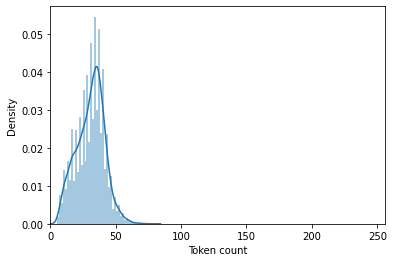

In [32]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [33]:
max(token_lens)

79

In [34]:
MAX_LEN = 85

In [35]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target =  self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [43]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.4, random_state=RANDOM_SEED)

In [44]:
df_train.shape, df_val.shape, df_test.shape

((6533, 5), (691, 5), (462, 5))

In [45]:
df.sentiment.to_numpy()

array([0, 0, 0, ..., 0, 2, 0])

In [46]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [47]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [48]:
finalTest_DL=create_data_loader(dft, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [49]:
dft


,airline,retweet_count,text,sentiment,airline_sentiment
0,Southwest,0,"@SouthwestAir I am scheduled for the morning, ...",0,
1,Delta,0,@JetBlue that is a stock response. Delays not ...,0,
2,Delta,0,@JetBlue That'd be nice! Hoping to rack up eno...,0,
3,Southwest,0,@SouthwestAir yeah haha. Never been in one. It...,0,
4,Delta,0,@JetBlue what's the easiest way to get a ticke...,0,
...,...,...,...,...,...
3289,Southwest,0,@SouthwestAir go south everyone,0,
3290,United,1,@united 3 times my flight has been delayed and...,0,
3291,Delta,0,"@JetBlue there is no supervisor available, so ...",0,
3292,US Airways,0,@USAirways even alternate options are allready...,0,


In [50]:
 df_test

,airline_sentiment,airline,retweet_count,text,sentiment
4370,neutral,Southwest,0,@SouthwestAir I am just wondering when are you...,1
4032,negative,American,1,@AmericanAir Thanks for your canned response t...,0
2921,negative,US Airways,0,@USAirways BF has been stuck in CLT all day. I...,0
5273,negative,American,0,@AmericanAir. It's been 5 hours and still no c...,0
1034,negative,United,0,@united who authors this fiction? I just heard...,0
...,...,...,...,...,...
5816,negative,American,1,@AmericanAir been calling 2 different offices ...,0
4302,neutral,Southwest,0,@SouthwestAir How can you get your TSA travele...,1
535,negative,United,0,@united WORST SERVICE EVER. Denied access to o...,0
2571,neutral,American,0,@AmericanAir but my friend was told she was ab...,1


In [51]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [52]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 85])
torch.Size([8, 85])
torch.Size([8])


In [53]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [54]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [55]:
# last_hidden_state.shape

In [56]:
bert_model.config.hidden_size

768

In [57]:
# pooled_output.shape

In [58]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    ) 
    pooled_output = output[1]
    output = self.drop(pooled_output)
    return self.out(output)

In [59]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [60]:
# !nvidia-smi

In [61]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) 
print(attention_mask.shape) 

torch.Size([8, 85])
torch.Size([8, 85])


In [62]:
import torch.nn.functional as F

In [63]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4823, 0.2281, 0.2896],
        [0.4315, 0.1269, 0.4416],
        [0.4823, 0.1313, 0.3865],
        [0.4444, 0.1055, 0.4502],
        [0.4407, 0.1427, 0.4166],
        [0.3719, 0.1664, 0.4616],
        [0.4307, 0.1767, 0.3926],
        [0.3841, 0.2241, 0.3919]], grad_fn=<SoftmaxBackward>)

In [70]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [71]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [72]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [73]:
import os
path=os.getcwd()+"/drive/MyDrive/bert/"

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), path+'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# y_review_texts, y_pred, y_pred_probs = get_predictions(
#   model,
#   test_data_loader
# )

In [ ]:
# print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
y_review_textsf, y_predf, y_pred_probsf, y_testf = get_predictions(
  model,
  finalTest_DL 
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
y_predf.shape[0]

3294

In [ ]:
Predicted=[]

In [ ]:
for i in range(y_predf.shape[0]):
               if(y_predf[i]==0):
                 Predicted+=['negative']
               elif(y_predf[i]==1):
                 Predicted+=['neutral']
               elif(y_predf[i]==2):
                 Predicted+=['positive']

In [ ]:
len(Predicted)

3294

In [ ]:
dff=pd.DataFrame(np.array(Predicted),columns=['Predicted'])

In [ ]:
dff.index.name='Id'

In [ ]:
dff.to_csv(path+'Predictions.csv')